# DSCI 563 Lab Assignment 3: Blogs (Cheat sheet)

## Assignment Objectives

In this assignment you will
- Convert a unlabeled blog corpus into a BOW representation
- Test whether dimensionality reduction with SVD preserves corpus variation in the context of clustering 
- Explore the corpus using the topics produced by an LDA topic model

## Getting Started

Run the code below to access relevant modules (you can add to this as needed)

In [2]:
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import TruncatedSVD,LatentDirichletAllocation
from sklearn.preprocessing import normalize
import zipfile
import re
from nltk import word_tokenize
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from random import seed

# Reproducibility
np.random.seed(0)
seed(0)

## Tidy Submission

rubric={mechanics:1}

To get the marks for tidy submission:

- Submit the assignment by filling in this jupyter notebook with your answers embedded
- Be sure to follow the [general lab instructions](https://ubc-mds.github.io/resources_pages/general_lab_instructions)
- Except you should not put the data in your lab repo, instead define the `path_to_data` below 

### Part 0: Prepare the corpus

#### Assignment 0.1
rubric={accuracy:3,efficiency:1, quality:1}

A zipped text file containing 8752 blog posts that we will use for this lab is provided in the data directory [here](https://github.com/jungyeul/mds-cl-2023-24/blob/main/block4/blogposts.zip). Download the zip-file but **don't push the data to github** (when grading your lab, the TA will otherwise end up with hundreds of megabytes of unwanted data, when pulling all the student repos). Update the `PATH_TO_DATA` variable below:

In [2]:
PATH_TO_DATA = "blogposts.zip" # change this!

In order to read the data, you should initialize a `ZipFile` object provided in the [zipfile]() module. You should first initialize a `ZipFile` object for the `blogposts.zip`. You can then use the member function `ZipFile.open()` to open the file `blogposts.txt` which is part of the zip archive `blogposts.zip`. You can then the the data in the usual way using the `read()` member function of the file object. 

**Note** that `read()` will return a `bytes` object, not a string. You will need to [decode](https://stackabuse.com/convert-bytes-to-string-in-python/) the data into `utf-8`. Since the data in `blogposts.txt` is not entirely clean, you will need to use the option `errors="ignore"`, when decoding. Otherwise, you'll get a `UnicodeDecodeError` error. 

using the  in the file into a variable `data`. 

After reading the data, you should convert it into a scipy sparse matrix format (i.e. the output of Scikit Learn vectorizers) where each row is a text and each column the count of words in the corpus. Each post is enclosed in an XML `<post>` tag which should not be include. For efficiency and quality, **we strongly recommend you extract the individual text strings corresponding to each text using `re.finditer` and `MatchObject.group` methods**. 

Your final representation vectors should:

- Be bag of words
- Be collapsed to all lowercase
- Have no punctuation
- Have no words that appear in less than 5 different texts:  `min_df=10` in `CountVectorizer`
- Have no words that appear in more than 10% of the texts: `max_df=0.2`

The Scikit-learn [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) is a good choice for doing this (it has options for all of the above), though you don't have to use it if you prefer to do something else. 

`CountVectorizer`:
- `max_dffloat` in range `[0.0, 1.0]` or `int, default=1.0`
When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.  **Have no words that appear in more than 10% of the texts**
- `min_dffloat` in range `[0.0, 1.0]` or `int, default=1`
When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None. **Have no words that appear in less than 5 different texts**

Store your vectorized blog posts as a matrix `post_X`.

`blogposts.txt`:

```
<post n="0">
\r\n\r\n\t \r\n         
I recently lost my job. I sort of wanted to lose it actually. Kind of like a relationship that no longer works. Im looking for a job now that doesnt involve much responsibility. too bad the nearest hot topics is at least 2 hours away. I wouldnt have to dress up for the job interview. when no one else is at home I like to play "setting sun" by the chemical brothers thru one blown speaker really loud while I perfect my robot dance. it keeps my neighbours on theyre toes. Im convinced one of my neighbours is actually a pirate.he has a beard,swords and exotic birds.he's an eyepatch away from pillaging the neighbourhood. I special ordered my monochrome black chuck taylor hi-tops, for job interviews and work.hard to find vegan work shoes. ... and the little girl washing dishes is my niece when she was about 3. I love that pic, you can read into it on so many different levels. a heavily photoshopped version is going to be used in flyers and as a single sleeve. and the pic of me was taken in riverside CA in a motel before the NOFX show and before the Absinthe started to kick in. thats Joe X. seated behind me and an Absinthe bottle by my hand. marta,please send some raNdom pics for me to put on here.
\r\n     \r\n\r\n    \r\n
</post>
```


utf-8 vs. iso 8859-15 (ASCII-based standard character encodings):
```
open("blogposts.txt")
                                                                      # of doc  # of vocab
corpus = f.read().decode("utf-8",errors="ignore")  -->  X_init.shape = (8752, 23345)
corpus = f.read().decode("iso 8859-15")            -->  X_init.shape = (8752, 23576)
```


`match.group(1)` vs. `match.group(0)`:
```
pattern = re.compile(r'<post n=NUM> (TEXT) </post>') 
for match in re.finditer(pattern, corpus):
    match.group(1).strip() vs. match.group(0).strip()
```

In [3]:
# https://docs.python.org/3/library/re.html

m = re.match(r"(\w+) (\w+),", "Isaac Newton, physicist")

#'Isaac Newton'
print('group()\t\t', m.group())       # The entire match, defaults to 0
#'Isaac Newton'
print('group(0)\t', m.group(0))       # The entire match


#'Isaac'
print('group(1)\t', m.group(1))       # The first parenthesized subgroup.

#'Newton'
print('group(2)\t', m.group(2))       # The second parenthesized subgroup.

#('Isaac', 'Newton')
print('group(1,2)\t', m.group(1, 2))    # Multiple arguments give us a tuple.

group()		 Isaac Newton,
group(0)	 Isaac Newton,
group(1)	 Isaac
group(2)	 Newton
group(1,2)	 ('Isaac', 'Newton')


In [4]:
from sklearn.feature_extraction.text import CountVectorizer

# your code here


Print out the shape of your matrix when you're done. You should end up with a sparse matrix with 8752 rows and about 23345 columns (it is okay if the second number is not exactly the same, but it should be close!):

In [5]:
assert post_X.shape[0] == 8752
# assert 23000 < post_X.shape[1] and post_X.shape[1] < 24000  
print("Success")

Success


### Part 1: Clustering with dimensionality reduced vectors

#### 1.1
rubric={accuracy:1}

L2 normalize the matrix `post_X` from Exercise 1 using [`sklearn.preprocessing.normalize`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html). Make sure that you are normalizing w.r.t. to the correct axis. **Hint** there are 8752 blog posts. 

You should preserve the original count matrix for later, so don't overwrite it. Instead store the normalized matrix as `post_X_norm`.

In [6]:
from sklearn.preprocessing import normalize

# your code here
# use  `normalize` using `post_X`; 

Assertion to check your code:

In [4]:
# post_X_norm[0]                    --> sparse matrix 

# post_X_norm[0].A                  --> array([[0., 0., 0., ..., 0., 0., 0.]])
# NOTE: a.toarray() or a.A 

# np.linalg.norm(post_X_norm[0].A)  --> return l2 norm by default

In [7]:
assert np.abs(np.linalg.norm(post_X_norm[0].A) - 1) < 0.0001
print("Success!")

Success!


#### 1.2

rubric={accuracy:2,viz:1}

Next, use the elbow method to identify a good *k* to cluster your blog data using k-means. With this much data, you will need to use [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans) instead of regular KMeans for this. You can increase the batch size to get a smoother curve, 500 should work well. You'll want to explore larger values of $k$ than the example in the clustering lecture, though don't go any higher than 100. You can use the code from the clustering lecture, with appropriate modifications.

- `batch_size = 500`
- `n_clusters = k` where $2 \leq k\leq 50$: `kmeanses = MiniBatchKMeans(n_clusters=k,batch_size=500,random_state=0).` 
- `inertia_` is defined as the sum of square distances of samples to their nearest neighbor: `kmeanses.inertia_`

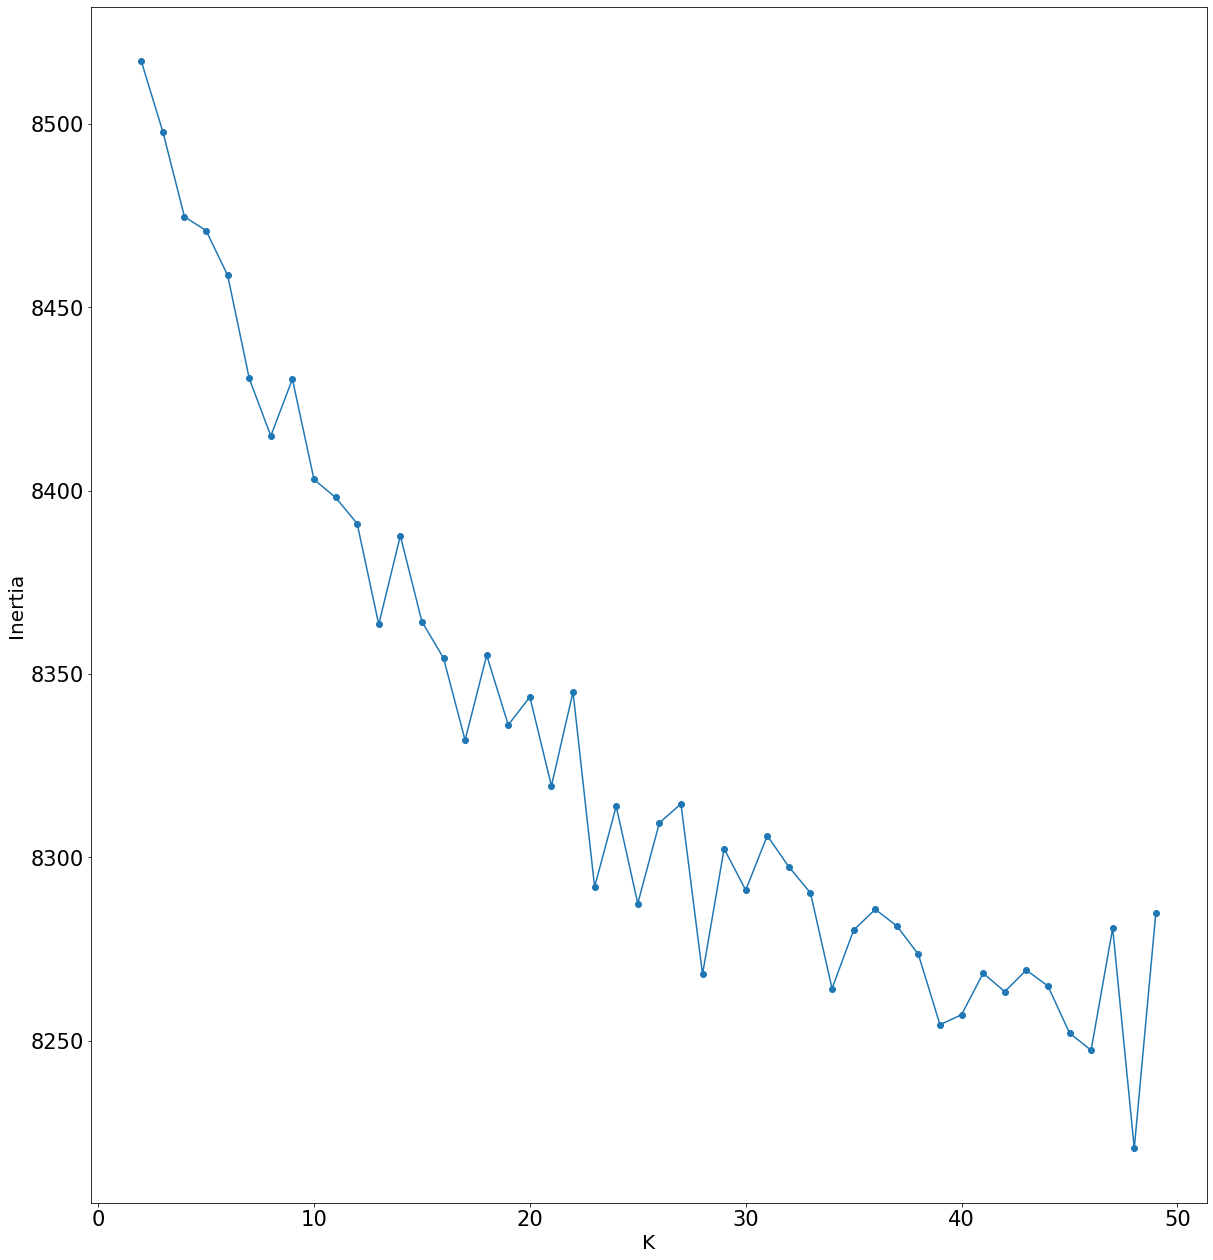

In [8]:
# your code here
def plot_inertia(kmeanses,start,end):
    ''' plot the inertia of the provided set of k-means which should correspond to the range of
    k values provided by start and end. No return value'''
    ...

# start = 2
# end = 50
    
# kmeanses = []
# for k in range(start,end):
#     kmeanses.append(MiniBatchKMeans(n_clusters = k,batch_size=500,random_state=0).fit(post_X_norm))

# plot_inertia(kmeanses,start,end)

#### 1.3
rubric={accuracy:2,quality:1}

In this exercise you're going to be comparing different clusterings of the dataset to see if they are consistent, using the **adjusted rand index** (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html) (ARI).  Note that the ARI is not really comparable across different numbers of clusters, so you'll have to stick to a single $k$ for the rest of this exercise, based on what you saw in 1.2. 

First, you're going to be looking at the consistency of clustering across different random iterations of k-means with the same data and parameters. You should run at least 10 different runs of k-means, exhaustively calculate the pairwise ARI for the resulting label set, and print out an average. It would be a good idea to use a function here, especially since you'll need to do this again later.

In order to compare two different clusterings, you should feed in the `labels_` arrays from different clusterings to the `adjusted_rand_score` function.

- using a single $k$
- `labels_`: `MiniBatchKMeans(n_clusters=k, batch_size=50, max_no_improvement=50,random_state=i).fit(X).labels_`
- at least 10 different runs of k-means, exhaustively calculate the *pairwise* ARI for the resulting label set: `adjusted_rand_score(r0,r1),adjusted_rand_score(r0,r2), adjusted_rand_score(r0,r3), ..., adjusted_rand_score(r2,r3),adjusted_rand_score(r2,r4), ..., adjusted_rand_score(r7,r8), ..., adjusted_rand_score(r8,r9)`
- print out an average


*The Rand index or Rand measure (named after William M. Rand) in statistics is a measure of the similarity between two data clusterings.* (source: https://en.wikipedia.org/wiki/Rand_index)


ARI is a symmetric measure: `adjusted_rand_score(a, b) == adjusted_rand_score(b, a)`

In [9]:
from sklearn.metrics import adjusted_rand_score

K=30 # number of cluster (you can decide the different number)

# your code here
def get_ari(n, X):
    kmeanses = []
    ...

    aris = []
    ...

    return sum(aris)/len(aris)

print("Mean ARI:",get_ari(10, post_X_norm)) # 10 = random state; (1..10)

Mean ARI: 0.2412055991173277


#### 1.4 (Optional)
rubric={reasoning:1}

There are a few hyperparameters for [`MiniBatchKMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans) which will influence clustering performance: e.g. `max_no_improvement`.

Test a few of the parameters of the $k$-means (other than $k$), trying to improve the consistency calculations from 1.3 (you should get to `> 0.4`) and discuss any major effects in the markdown box below. Keep the best scoring parameters in your final version; you'll be using them for the result of this exercise.

#### 1.5 (Optional)
rubric= {reasoning:1}

Write a function that gives you lists of posts for a given clustering of the data. Using the parameters you choose above, do a run of k-means, select a cluster of medium size (it shouldn't be the largest or the smallest), print out the list of post ids, and inspect texts from that cluster (at least 5) until you can identify some commonality among posts in the cluster. If you can't make any sense of the cluster, try another one; it might also help to compare the cluster you pick with another. Write your conclusion in the box below, providing some examples of the language from different posts.

In [ ]:
# your code here


#### 1.6
rubric= {accuracy:1}

Now use truncated singular value decomposition to lower the dimensionality of the dataset, with k=500. You should use the original data matrix `post_X` here. Store the resulting `np.array` as `post_X_500`.

`TruncatedSVD` https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html: `n_components = 500`

<!-- Desired dimensionality of output data. Must be strictly less than the number of features. The default value is useful for visualisation. For LSA, a value of 100 is recommended. -->

In [5]:
# your code here
svd = TruncatedSVD(...) 
# then, fit_transform()

#### 1.7
rubric= {accuracy:1}

Plot the singular values of `post_X_500`, and pick a sensible new dimensionality, n, n < k, based on what you see (using again the elbow method)

- plot the singular values (`singular_values_`) where $k=500$
- pick a sensible new dimensionality $n$ where  $n < k$

**The singular value decomposition (SVD) of an $m \times n$ matrix $\mathbf{M}$ is a factorization of the form  ${\displaystyle \mathbf {U\Sigma V^{*}} }$, 
where the diagonal entries ${\displaystyle \sigma _{i}=\Sigma _{ii}}$ of $\mathbf{\Sigma}$ are known as the singular values of $\mathbf {M}$**

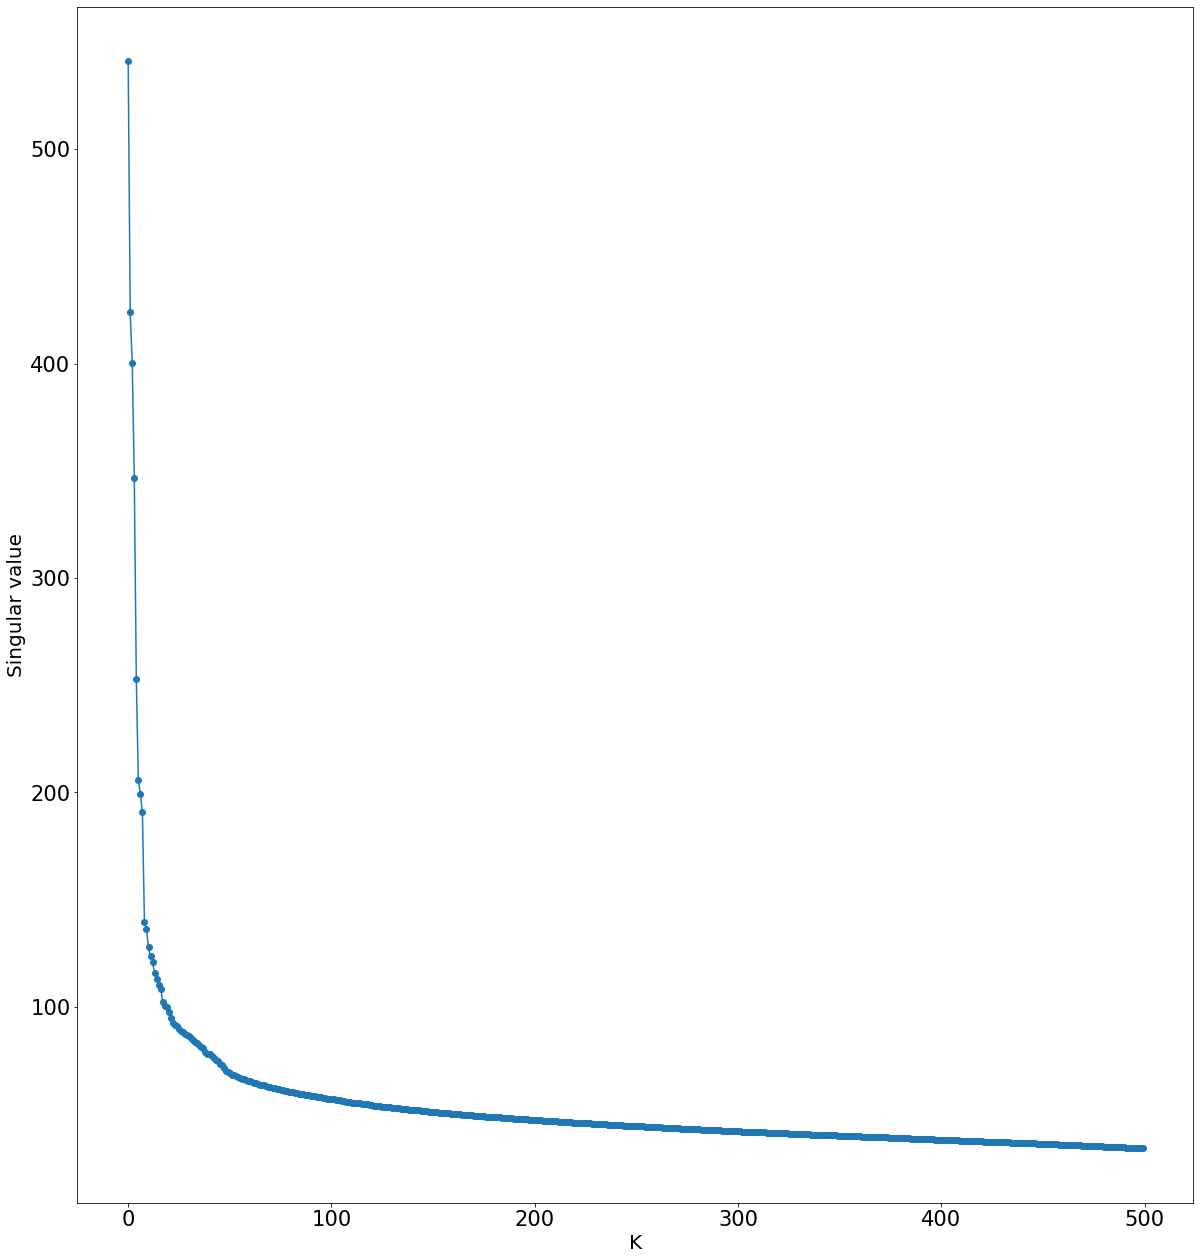

In [11]:
# your code here

# svd.singular_values_
def plot_svd(svd):
    ...
    plt.plot(range(len(svd.singular_values_)),svd.singular_values_ , '-o');

plot_svd(svd)

#### 1.8
rubric= {accuracy:3,quality:1, efficiency:1}

At this point, you have two matrix representations of the data:

1. Original BOW representation (`post_X_norm`)
2. SVD with k=500 (`post_X_500`)

You will now create two more matrix representations of the data:

3. SVD with k=n, where $n$ is based on your elbow analysis from 1.7 (this will have $n$ columns) **`post_X_0_to_n`**
4. SVD version using the columns between $n$ and 500. (this will have 500 - $n$ columns) **`post_X_n_to_500`**

You can create 3 and 4 just by slicing `post_X_500`, **you don't need to run TruncatedSVD again.**

Then, do the same kind of consistency analysis you did in 1.3, but this time using each of matrices 2, 3, and 4. Again, you are creating 10 clusterings for each, and then exhaustively pairing those 10 with each other and checking their consistency using the adjusted rand score.

Your final experiment here will involve testing the clustering label consistency between 1 (the original dataset) and each of the three other matrices. Instead of exhaustively pairing a list of clusterings derived from a single representation (as you did in 1.3 and directly above) to check how consistent the clusterings are, you will be exhaustively pairing two lists of 10 clusterings, one list of clusterings derived using Matrix 1 (i.e. the original representation), and one of clusterings from one of the other three matrices (in 1.3 you were doing comparisons analogous to "pdist", whereas here you are doing something analogous to "cdist"). 

This should result in 3 average consistency values, one for each of matrices 2, 3, and 3, which you should take as a measure of how well each representation is able to preserve the information in the original for the purposes of clustering. With the results for 2, 3, and 4 for the internal consistency testing, you should be displaying a total of 6 numbers here, make sure you clearly identify which is which! For full points, use functions, and try to avoid redoing the same clustering again and again.

![ARI](ari.png)

In [12]:
# your code here
def get_pairwise_ari(n, X1, X2):
    ...

    return sum(aris)/len(aris)



print("Internal consistency:")
print("Mean ARI 0-500:",get_ari(10, post_X_500))
print("Mean ARI 0-50:",get_ari(10, post_X_0_to_50))
print("Mean ARI 50-500:",get_ari(10, post_X_50_to_500))
print()

print("Consistency with original matrix X_norm:")
print("Mean pairwise ARI 0-500:",get_pairwise_ari(10, post_X_500, post_X_norm))
print("Mean pairwise ARI 0-50:",get_pairwise_ari(10, post_X_0_to_50, post_X_norm))
print("Mean pairwise ARI 50-500:",get_pairwise_ari(10, post_X_50_to_500, post_X_norm))
print()


Internal consistency:
Mean ARI 0-500: 0.40476322922222124
Mean ARI 0-n: 0.40662565675209567
Mean ARI n-500: 0.11565950967337822

Consistency with original matrix X_norm:
Mean pairwise ARI 0-500: 0.22411167928519402
Mean pairwise ARI 0-n: 0.029953040289766763
Mean pairwise ARI n-500: 0.008391580298367741



#### 1.9
rubric= {reasoning:2}

Interpret the relative performance of the three vector representations based on what you understand about SVD. In particular, you should discuss whether your choice of k from 1.7 (using the elbow method) seems to be a good one, in terms of preserving the information contained in the original document representation.

### Part 2: Topic modelling


#### 2.1
rubric={accuracy:1}

Using the blog data, build an LDA model with 100 topics. Use online learning, and set the verbosity option to 2 and evaluate_every to 1, so the you can see the process of training and the perplexity after each iteration. Increase the total number of iterations and run again if perplexity has not converged (you can say it has coveraged if there is less than a 5 point drop in perplexity in the final iteration). This will take a while, so work on something else while you wait....


Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent Dirichlet Allocation. *Journal of Machine Learning Research*, 3(4–5), 993–1022.

For `post_X`:
- `LatentDirichletAllocation`: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
- 100 topics `n_components`,
- use `"online"` as a `learning_method`
- `verbosity` option = **0**, otherwise, it prints A LOT. 
- `evaluate_every` = 1



In [6]:
# your code here, takes time to run... (>13min)

lda = LatentDirichletAllocation(...)

#### 2.2
rubric={accuracy:3}

For each topic in the model, print out the topic number (0 to 99), the sum of the corresponding row of `components_ (lda.components_)` (the total psuedo counts for that topic), and the 15 words which have the highest number of psuedocounts (in components_) for that topic, high count word first. **Hint:** the CountVectorizer that you built in Part 0 will be needed here, because you can use it to translate feature index numbers into words. 

You should **exclude topic words which have a psuedocount of less than 5**. It's possible that some topics end up with an empty list of words after filtering filter step, but that's okay.

In [14]:
# your code here

# see lecture6.ipynb for psuedocount

Topic number: 0, 1743.7076053572612
['earnings', 'waking', 'hawaiian', 'whitney', 'sleeping', 'reserves', 'decide', 'spouses', 'unreal', 'wakes', 'wake', 'alarm', 'cop', 'roommate', 'oil']
Topic number: 1, 440.1539446375031
['mfa', 'rearranged', 'storefront', 'gamut', 'twinge', 'disruptive', 'kkz', 'dw', 'creatively', 'bert', 'strained', 'catering', 'samples', 'su', 'dh']
Topic number: 2, 233.4500025959183
[]
Topic number: 3, 123997.5974547193
['experience', 'sense', 'list', 'personal', 'important', 'upon', 'art', 'given', 'sort', 'paper', 'form', 'earth', 'simple', 'level', 'children']
Topic number: 4, 274.0810993979361
['ante', 'memoirs', 'sanchez', 'railroad']
Topic number: 5, 674.0413243279248
['fixation', 'blvd', 'hostage', 'shuffled', 'fireman', 'digit', 'hurried', 'zoe', 'cadet', 'nasa', 'mikey', 'spidey', 'auditorium', 'jill', 'tyler']
Topic number: 6, 13628.576146515303
['weapons', 'peace', 'absinthe', 'vietnam', 'evil', 'michael', 'fighting', 'union', 'history', 'soldiers', '

/Users/jungyeul/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### 2.3
rubric={raw:2}

Next, pick an appropriate topic label for those topics from the list you just created that you judge to be a "good" topic. Look for topics where you can identify a clear theme in their words (it is okay if there a few words that don't make sense), and where the sum of psuedocounts is fairly high but not too high (There are always a few "kitchen sink" garbage topics). You should create a dictionary which maps from the label to the index: e.g. 

`topic_dict = {"animals":0, "geography":1, ...}`

In [8]:
# your code here to make your dict "manually"

topic_dict = {...}

#### 2.4
rubric={accuracy:3,quality:1}

Build a retrieval system which takes a list of topics like `["technology", "food"]` (i.e. a query) and displays documents from your corpus which contain the desired set of topics. 

Your (main) function should take a list of topics, and the number of top-ranked matches you want to see. You should only **display texts whose topic proportions are 2 standard deviations above the topic proportion mean**, that is, a z-score greater than 2 for all topics in the query (`zscores >= 2`). Your function should return the count of all texts which meet this bar in addition to the actual results. 

The ranking of the displayed documents should be based on the z-score among the topics asked for, i.e. a higher z-score is better. When there are multiple topics in the same query, you should use the *lowest* z-score among the topic z-scores for comparison. E.g. let's say the query contains the topics `["technology", "food"]`, and the z-score of `doc1` is 2.1 for `"tecnhology"` and 3.5 for `"food"`, and the z-score for `doc2` is 2.2 for `"technology"` and 2.3 for `"food"`. Then, `doc2` should be ranked higher in the results. (2.1 `<` 2.2)

Print out a few examples that show that your retreival system is working, including at least one case with multiple topics.

**Hint:** `scipy.stats.zscore` (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html), note that you should specify the axis or flatten your data into a 1-dimensional array.

In [9]:
from scipy.stats import zscore
# A z-score measures exactly how many standard deviations above or below the mean a data point is.

MIN_Z_SCORE=2

# your code here
def get_topics(post_X, data, topic_list, n_texts, topic_dict):
    topic_set = set([topic_dict[t] for t in topic_list])
    matches = []  # (min() of zscores, post)

    X = lda.transform(post_X)
    # for post, doc_vector in zip(data, post_X)
    #     zscores = zscore( ... should be 1D)
    #     find topic(s) where topic's zscores[i] >= MIN_Z_SCORE
    #     if verify topics (zscores >= 2) are food and technology
    #         then, matches.append((min() of zscore, pos))

    matches.sort(reverse=True)

    return len(matches), [post 'from' matches[:n_texts]]

get_topics(post_X, posts, "food technology".split(), 3, topic_dict)



#### 2.5 (Optional)
rubric={accuracy:1}

Modify your code above to print out the top 5 ranked words for each topic in the query for each result, and rerun your examples.

**Hint:** the CountVectorizer that you built in Part 0 will be needed here, because you can use it to translate feature index numbers into words. 

In [ ]:
# your code here


#### 2.6 (Optional)
rubric={reasoning:1}

Play around with your topic search engine using a diversity of topic combinations, and print out two results lists that you find which have at least one correct and one incorrect result (incorrect meaning that at least one of the topics cannot be applied properly to the passage). Explain why you think the incorrect results happened, with reference to the limitations of the LDA model or perhaps errors in your topic naming.

In [ ]:
# your code here
